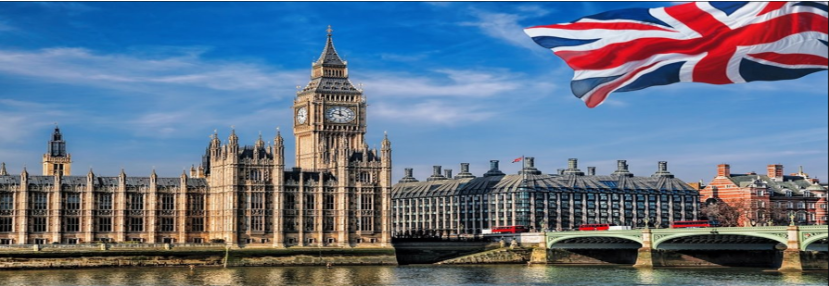 
<h1 align="center"> Revenue Performance Analysis with Python</h1>

### Description:

As an analyst for ProWidget Systems, a UK-based B2B (business-to-business) retailer, I’ve been asked to report on spending for London-based customers versus those based in the rest of the United Kingdom.  

The board want to know:
- Which UK cities are currently underserved
- Whether their customers are primarily London based

### My Approach

I approached this project with a structured, data-driven and business-centric methodology focused on uncovering actionable insights.

After understanding the core business problem, which is to determine how much revenue London generated compare with other cities across the United Kingdom, and to identify which cities are truly underserved, the methodology I applied includes:

- **Define the analytical objective clearly**, as it serves as the foundation of the entire project.
The goal is to measure London’s contribution relative to the rest of the cities and to determine underserved areas using multi-dimensional KPIs. The expected output includes comparative charts, city-level KPIs, and a validated underserved-score ranking.  

- **Explore and prepare the data**, checking for missing values, formatting inconsistencies, and understand the meaning and structure of each variable.  

- **Perform the analysis in a layered approach**, starting with revenue and transaction distributions, then extending to company-level metrics such as spend per company, company share, and spend share. These metrics are normalized and combined into a final underserved score to ensure a fair and accurate comparison across cities.  

- **Communicate the findings in a clear and decision-orented manner**, highlighting London’s actual influence, identifying the lowest-performing and underserved cities, and presenting findings in a way that supports strategic and market-expansion decisions.

In [24]:
# Load the data
import pandas as pd
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', None)

customers = pd.read_csv("addresses.csv")
print(customers.head())
print('-----------------------')
print(customers.shape)

   company_id                                            address  total_spend
0           1  APARTMENT 2,\n52 BEDFORD ROAD,\nLONDON,\nENGLA...         5700
1           2           107 SHERINGHAM AVENUE,\nLONDON,\nN14 4UJ         4700
2           3  43 SUNNINGDALE,\nYATE,\nBRISTOL,\nENGLAND,\nBS...         5900
3           4  HAWESWATER HOUSE,\nLINGLEY MERE BUSINESS PARK,...         7200
4           5  AMBERFIELD BARN HOUSE AMBER LANE,\nCHART SUTTO...         4600
-----------------------
(100000, 3)


## Data Understanding

In [25]:
# Investigating the missing values
customers.isna().sum()

company_id       0
address        968
total_spend      0
dtype: int64

>We see 968 adresses missing out of 100.000. Because its less than 1% of the entire data, we find its less relevant, so we are going the drop its.

In [26]:
# Delete the rows with missing addresses
customers = customers.dropna(subset=['address'])
print(customers.isna().sum())
print(customers.shape)

company_id     0
address        0
total_spend    0
dtype: int64
(99032, 3)


In [27]:
# Explore the numerical column (total_spend)
customers.total_spend.describe()

count    99032.000000
mean      4951.673197
std       1500.642398
min          0.000000
25%       3900.000000
50%       5000.000000
75%       6000.000000
max      11700.000000
Name: total_spend, dtype: float64

>We see values start from 0 to almost 12,000, so no negative values.
>
>At the first glance, we can see that there are positive outliers due to the difference between the IQR and the maximum.
>
>So, because we don't have a lot of variables - like number of items, number of purchases and son on - that can allow us to go further, we'll take it like this and it could be a way to go back to the stackeholders in the real-life to ask more questions.

In [28]:
# Extracting city column from address
for address in customers.address.head():
    print(address, '\n')

APARTMENT 2,
52 BEDFORD ROAD,
LONDON,
ENGLAND,
SW4 7HJ 

107 SHERINGHAM AVENUE,
LONDON,
N14 4UJ 

43 SUNNINGDALE,
YATE,
BRISTOL,
ENGLAND,
BS37 4HZ 

HAWESWATER HOUSE,
LINGLEY MERE BUSINESS PARK,
LINGLEY GREEN AVENUE,
GREAT SANKEY, WARRINGTON,
WA5 3LP 

AMBERFIELD BARN HOUSE AMBER LANE,
CHART SUTTON,
MAIDSTONE,
ENGLAND,
ME17 3SF 



> It appears that addresses end with the postcode, but sometimes London addresses contain a line for England, and sometimes they don’t.
>
> What about looking for the string “London” to identify customers in London? Would that be enough? Probably not. We would end up including people who live on “London Road” in other towns.
>
> In our sample (first rows), all addresses were uppercase, but we should not assume this will be the case for all 100,000 rows, so we should ensure they are all uppercase ourselves.

## Data Preparation

In [29]:
import warnings
warnings.filterwarnings('ignore')

# Create a cleaned address 
customers['address_clean'] = customers.address.str.upper()

print(len(customers[customers.address_clean.str.contains('LONDON')]))
print(len(customers[customers.address_clean.str.contains('LONDON,')]))

21768
20831


> The output of these lines of code is 21,768 and 20,831, respectively, which means nearly 1,000 rows are no longer selected when we add the commas

In [30]:
# let the number of component related to address structure (specifically separated by \n)
customers['address_lines'] = customers.address_clean.str.split(',\n').apply(len)

print(customers.address_lines.value_counts())

address_lines
5    45931
4    35850
6    13909
3     3284
2       52
1        6
Name: count, dtype: int64


> Let assume the complete address have 6 elements:
> Apart No,
> Street No Street name,
> City,
> Province/Territory code,
> Postal code
> Country
> 
> In our data we observe some addresses with of only one or two lines.

In [31]:
customers.columns

Index(['company_id', 'address', 'total_spend', 'address_clean', 'address_lines'], dtype='object')

In [32]:
# Let examine how look the shorter addresses
print(customers.loc[customers['address_lines'] == 1, 'address_clean'])
print('-----------------------------------------')
print(customers[customers['address_lines'] == 2].sample(5, random_state=1) ['address_clean'])

17789                      FALKIRK
31897                   HADDINGTON
61750          CREAG BHAITHEACHAIN
75330                     NEWMILNS
78045    REDCLOAK FARM, STONEHAVEN
90897     REFER TO PARENT REGISTRY
Name: address_clean, dtype: object
-----------------------------------------
62736    BRANCH REGISTRATION,\nREFER TO PARENT REGISTRY
5343                     7 RUTLAND SQUARE,\nEDINBURGH 1
81020                            EASTER SOFTLAW,\nKELSO
64065                  242 WEST GEORGE STREET,\nGLASGOW
60867                       1 GEORGE STREET,\nEDINBURGH
Name: address_clean, dtype: object


> We see the variability in our data.
> Some rows are simply a city (Falkirk, Haddington...);
> there are entirely missing addresses referring us to a parent registry;
> and we also have PO Box addresses.
> It is unlikely we can come up with a rule to extract cities purely based on their position in the lines of an address without writing a lot of bespoke code.
>
> Just to recenter everything, my goal here is to create a city column.
> Due to the bunch of ways in the address column, we would require a comprehensive list of cities in the united Kingdom, which is provided by the UK government and match it with the recorded database received.

After visiting the site https://www.gov.uk/government/publications/list-of-cities/list-of-cities-html, there is a list of just 76 cities, so I've copied and pasted it into Excel.

In [33]:
# Load my cities file created.
cities = pd.read_csv('cities.csv', header=None, names=['city'])
print(cities.head())
print('---------------------------')
print(cities.shape)

              city
0          England
1             Bath
2      Birmingham*
3        Bradford*
4  Brighton & Hove
---------------------------
(80, 1)


> The shape shows 80 rows while we know is 76, that means we've copied also the header of cities which is the countries
> 
> So that heading values England, Scotland, Wales, and Northern Ireland need to be removed.
> 
> Then, the trailing asterisk * character also needs to be trimmed, and the remaining city names should be uppercased to match our address data.

In [34]:
# Cleaning cities list
cities = cities[~cities['city'].isin(['England', 'Scotland', 'Wales', 'Northern Ireland'])]
cities = cities.dropna(subset=['city'])

cities['city'] = cities['city'].str.replace('*', '', regex=False) # Delete the astherisk

cities['city'] = cities['city'].str.upper() # COnvert its in uppercase
cities.head()

,city
1,BATH
2,BIRMINGHAM
3,BRADFORD
4,BRIGHTON & HOVE
5,BRISTOL


Now, we will tag the address in our own DataFrame to the ones imported on the UK gov website.

In [35]:
for city in cities['city'].values:
    customers.loc[customers['address_clean'].str.contains(f"\n{city},"), 
    'city'] = city
    
customers['city'] = customers['city'].fillna('OTHER')
customers.head()

,company_id,address,total_spend,address_clean,address_lines,city
0,1,"APARTMENT 2,\n52 BEDFORD ROAD,\nLONDON,\nENGLA...",5700,"APARTMENT 2,\n52 BEDFORD ROAD,\nLONDON,\nENGLA...",5,LONDON
1,2,"107 SHERINGHAM AVENUE,\nLONDON,\nN14 4UJ",4700,"107 SHERINGHAM AVENUE,\nLONDON,\nN14 4UJ",3,LONDON
2,3,"43 SUNNINGDALE,\nYATE,\nBRISTOL,\nENGLAND,\nBS...",5900,"43 SUNNINGDALE,\nYATE,\nBRISTOL,\nENGLAND,\nBS...",5,BRISTOL
3,4,"HAWESWATER HOUSE,\nLINGLEY MERE BUSINESS PARK,...",7200,"HAWESWATER HOUSE,\nLINGLEY MERE BUSINESS PARK,...",5,OTHER
4,5,"AMBERFIELD BARN HOUSE AMBER LANE,\nCHART SUTTO...",4600,"AMBERFIELD BARN HOUSE AMBER LANE,\nCHART SUTTO...",5,OTHER


Now let's explore the new city column

In [36]:
customers['city'].nunique()

75

In [37]:
# Count the number of city 
customers.city.value_counts().head()

city
OTHER         54458
LONDON        20762
MANCHESTER     1902
BIRMINGHAM     1866
GLASGOW        1273
Name: count, dtype: int64

> Over half of our data is in the "OTHER" category, which means half of our customer base is established outside of major cities.

In [38]:
# Display some cities in "OTHER" category
sample_other = customers[customers['city'] == "OTHER"].sample(5, random_state=0)
for address in sample_other['address_clean'].values:
    print(address, "\n")

7 RILEY ROAD,
ENFIELD,
UNITED KINGDOM,
EN3 5QB 

OFFICE 24,
RURAL INNOVATION CENTER,
STONELEIGH,
UNITED KINGDOM,
CV8 2LG 

140 MORELAND ROAD,
SOUTH SHIELDS,
UNITED KINGDOM,
NE34 8NJ 

44 THE PANTILES,
TUNBRIDGE WELLS,
ENGLAND,
TN2 5TN 

C/O MOLECULAR PRODUCTS LIMITED PARKWAY,
HARLOW BUSINESS PARK,
HARLOW,
ESSEX,
ENGLAND,
CM19 5FR 



> Some of these addresses relate to towns, but there is an address in Twickenham, which is a suburban district in London. While the address did not contain the word “London,” that customer should be categorized as being London based. 

**Note:** Unless you have knowledge of UK geography, you may miss these instances of London addresses without the word “London” in them. This highlights how important domain knowledge is for an analyst and why you should work closely with domain experts.

In [39]:
# Checking the cities correspondents in both DataFrame
missing_in_customers = set(cities['city'].str.upper()) - set(customers['city'].str.upper())
extra_in_customers = set(customers['city'].str.upper()) - set(cities['city'].str.upper())

summary = pd.DataFrame({
    'missing_in_customers': sorted(missing_in_customers),
    'extra_in_customers': sorted(extra_in_customers)
})
summary

,missing_in_customers,extra_in_customers
0,KINGSTON-UPON-HULL,OTHER


> This means the city Kingston-Upon-Hull is not in the city columns of our customer address data.

We think that the city is usually abbreviated to just "Hull" which again is a case of applying specific domain knowledge to the problem.<br>
So, let's look for that in our adddress data

In [40]:
customers[customers["address_clean"].str.contains("\nHULL")].head()

,company_id,address,total_spend,address_clean,address_lines,city
455,456,"349 BEVERLEY ROAD,\nANLABY,\nHULL,\nENGLAND,\n...",3800,"349 BEVERLEY ROAD,\nANLABY,\nHULL,\nENGLAND,\n...",5,OTHER
1139,1140,"90 CALVERT LANE,\nHULL,\nENGLAND,\nHU4 6BJ",6000,"90 CALVERT LANE,\nHULL,\nENGLAND,\nHU4 6BJ",4,OTHER
1822,1823,"ACER GLADE BLACK TUP LANE,\nARNOLD,\nHULL,\nEN...",4600,"ACER GLADE BLACK TUP LANE,\nARNOLD,\nHULL,\nEN...",5,OTHER
1831,1832,"10 GORDON STREET,\nHULL,\nENGLAND,\nHU3 3HN",5300,"10 GORDON STREET,\nHULL,\nENGLAND,\nHU3 3HN",4,OTHER
1921,1922,"70 WRIGHT STREET,\nHULL,\nENGLAND,\nHU2 8JD",6100,"70 WRIGHT STREET,\nHULL,\nENGLAND,\nHU2 8JD",4,OTHER


> We see many addrresses named like that, so we will change their cities OTHER by KINGSTON-UPON-HULL

In [41]:
customers.loc[customers["address_clean"].str.contains("\nHULL"), "city"] = "KINGSTON-UPON-HULL"

In [42]:
customers.city.value_counts().head()

city
OTHER         54164
LONDON        20762
MANCHESTER     1902
BIRMINGHAM     1866
GLASGOW        1273
Name: count, dtype: int64

>It decreases the OTHER by 294 

Now I think I've done the data wrangling, let's analyze the spending

## Analysis

In [43]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

# -------------------------------
# 1. DATA PREPARATION
# -------------------------------

# Top 10 cities by total spend
top_10_spend = (
    customers.groupby("city", as_index=False)["total_spend"].sum()
    .sort_values(by="total_spend", ascending=False)
    .head(10)
)

# Top 10 cities by number of transactions
top_10_transactions = (
    customers.groupby("city", as_index=False)
    .size()
    .rename(columns={"size": "transaction_count"})
    .sort_values(by="transaction_count", ascending=False)
    .head(10)
)

# -------------------------------
# 2. SUBPLOTS LAYOUT
# -------------------------------

fig = make_subplots(
    rows=1,
    cols=2,
    subplot_titles=(
        "Top 10 Cities by Total Spend",
        "Top 10 Cities by Number of Transactions"
    ),
    horizontal_spacing=0.15  # space between charts
)

# -------------------------------
# 3. LEFT GRAPH — Total Spend
# -------------------------------

fig.add_trace(
    go.Bar(
        x=top_10_spend["total_spend"],
        y=top_10_spend["city"],
        orientation="h",
        marker=dict(
            color=top_10_spend["total_spend"],
            colorscale="Viridis"
        ),
        hovertemplate="<b>%{y}</b><br>Total Spend: £%{x:,.0f}<extra></extra>",
    ),
    row=1, col=1
)

# Reverse y-axis for left chart
fig.update_yaxes(autorange="reversed", row=1, col=1)

# -------------------------------
# 4. RIGHT GRAPH — Transactions
# -------------------------------

fig.add_trace(
    go.Bar(
        x=top_10_transactions["transaction_count"],
        y=top_10_transactions["city"],
        orientation="h",
        marker=dict(
            color=top_10_transactions["transaction_count"],
            colorscale="Viridis"
        ),
        hovertemplate="<b>%{y}</b><br>Transactions: %{x:,}<extra></extra>",
    ),
    row=1, col=2
)

fig.update_yaxes(autorange="reversed", row=1, col=2)

# -------------------------------
# 5. FINAL LAYOUT
# -------------------------------

fig.update_layout(
    width=1200,
    height=650,
    template="plotly_white",
    showlegend=False,
    xaxis_title="Total Spend (£)",
    xaxis2_title="Number of Transactions",
)

fig.show()


> The group OTHER is at the top in term of spendings and transactions, it might include isle of Man and the overseas Territories.
> 
> It is followed by LONDON, whose spending and transactions are +10 times more than its closest follower city

In [44]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# -------------------------------
# 1. DATA PREPARATION
# -------------------------------

# Lowest 10 cities by total spend
lowest_10_spend = (
    customers.groupby("city", as_index=False)["total_spend"].sum()
    .sort_values(by="total_spend", ascending=True)
    .head(10)
)

# Lowest 10 cities by number of transactions
lowest_10_transactions = (
    customers.groupby("city", as_index=False)
    .size()
    .rename(columns={"size": "transaction_count"})
    .sort_values(by="transaction_count", ascending=True)
    .head(10)
)

# A soft "low" color (edit if you prefer)
low_color = "#A9AFC1"   # muted gray-blue


# -------------------------------
# 2. SUBPLOTS LAYOUT
# -------------------------------

fig = make_subplots(
    rows=1,
    cols=2,
    subplot_titles=(
        "Lowest 10 Cities by Total Spend",
        "Lowest 10 Cities by Number of Transactions"
    ),
    horizontal_spacing=0.20
)

# -------------------------------
# 3. LEFT GRAPH — Lowest Spend
# -------------------------------

fig.add_trace(
    go.Bar(
        x=lowest_10_spend["total_spend"],
        y=lowest_10_spend["city"],
        orientation="h",
        marker=dict(color=low_color),
        hovertemplate="<b>%{y}</b><br>Total Spend: £%{x:,.0f}<extra></extra>",
    ),
    row=1, col=1
)

fig.update_yaxes(autorange="reversed", row=1, col=1)

# -------------------------------
# 4. RIGHT GRAPH — Lowest Transactions
# -------------------------------

fig.add_trace(
    go.Bar(
        x=lowest_10_transactions["transaction_count"],
        y=lowest_10_transactions["city"],
        orientation="h",
        marker=dict(color=low_color),
        hovertemplate="<b>%{y}</b><br>Transactions: %{x:,}<extra></extra>",
    ),
    row=1, col=2
)

fig.update_yaxes(autorange="reversed", row=1, col=2)

# -------------------------------
# 5. FINAL LAYOUT
# -------------------------------

fig.update_layout(
    width=1200,
    height=650,
    template="plotly_white",
    showlegend=False,
    xaxis_title="Total Spend (£)",
    xaxis2_title="Number of Transactions",
)

fig.show()


> These charts show that the same cities consistently appear at the bottom in both total spend and number of transactions, indicating very weak commercial activity in these regions. Cities like `Lisburn`, `Bangor`, `Armagh`, `Wells` and `Ripon` form the lowest tier, while places such as `St Davids`, `Brighton & Hove` and `Newcastle-upon-Tyne` show almost no meaningful contribution to revenue or volume. 
>
> Overall, these locations do not present immediate growth opportunities and can be safely deprioritized in favour of higher-performing markets.

In [79]:
import plotly.graph_objects as go
import pandas as pd

# --- 1. Compute base aggregations ---
city_groups = customers.groupby("city").agg(
    total_spend=("total_spend", "sum"),
    nb_companies=("total_spend", "count"),
    avg_price=("total_spend", "mean")
)

# --- 2. Extract groups ---
london = city_groups.loc["LONDON"] if "LONDON" in city_groups.index else None
other = city_groups.loc["OTHER"] if "OTHER" in city_groups.index else None
rest = city_groups.drop(["LONDON", "OTHER"], errors="ignore")

# --- 3. Build summary rows ---
summary_rows = [
    ["LONDON", london["nb_companies"], london["avg_price"], london["total_spend"]],
    ["OTHER", other["nb_companies"], other["avg_price"], other["total_spend"]],
    [
        "REST OF UK",
        rest["nb_companies"].sum(),
        rest["total_spend"].sum() / rest["nb_companies"].sum(),
        rest["total_spend"].sum()
    ]
]

summary_df = pd.DataFrame(summary_rows, columns=["City", "Nb Companies", "Avg Price", "Total Spend"])

# --- 4. TOTAL row ---
total_nb = summary_df["Nb Companies"].sum()
total_spend = summary_df["Total Spend"].sum()
total_avg = total_spend / total_nb if total_nb > 0 else 0

summary_df.loc[len(summary_df)] = ["TOTAL", total_nb, total_avg, total_spend]


# =======================  PIE CHART  =======================

# Use summary_df (numeric), but only the 3 city groups (no TOTAL)
pie_df = (
    summary_df[summary_df["City"].isin(["LONDON", "OTHER", "REST OF UK"])]
    .set_index("City")
    .loc[["LONDON", "REST OF UK", "OTHER"]]      # enforce order
    .reset_index()
)

colors = [
    "#53F597",  # LONDON - green
    "#48AA73",  # OTHER - blue
    "#84A88E"   # REST OF UK - grey
]

fig_pie = go.Figure(
    data=[
        go.Pie(
            labels=pie_df["City"],
            values=pie_df["Total Spend"],
            marker=dict(colors=colors),
            textinfo="percent",   # % on slices
            hovertemplate="<b>%{label}</b><br>Total Spend: £%{value:,.0f}<extra></extra>"
        )
    ]
)

fig_pie.update_layout(
    title="Share of Total Spend by City Group",
    width=600,
    height=500
)

fig_pie.show()

# =====================  END PIE CHART  =====================


# --- 5. Format for display (TABLE) ---
df_display = summary_df.copy()
df_display["Nb Companies"] = df_display["Nb Companies"].apply(lambda x: f"{x:,}")
df_display["Avg Price"] = df_display["Avg Price"].apply(lambda x: f"£{x:,.2f}")
df_display["Total Spend"] = df_display["Total Spend"].apply(lambda x: f"£{x:,.0f}")

# --- 6. Row colors (TOTAL highlighted) ---
row_colors = []
for i in range(len(df_display)):
    if df_display.loc[i, "City"] == "TOTAL":
        row_colors.append("#E8E8E8")   # highlight
    else:
        row_colors.append("#F9F9F9" if i % 2 == 0 else "white")  # alternating

# --- 7. Bold TOTAL row ---
font_styles = []
for i in range(len(df_display)):
    if df_display.loc[i, "City"] == "TOTAL":
        font_styles.append("bold")
    else:
        font_styles.append("normal")

# --- 8. Plotly Table ---
fig = go.Figure(
    data=[
        go.Table(
            header=dict(
                values=[
                    "<b>City</b>",
                    "<b>Nb Companies</b>",
                    "<b>Avg Price</b>",
                    "<b>Total Spend</b>"
                ],
                fill_color="#6CB3E6",
                font=dict(color="white", size=14),
                align="left",
                height=40   # more height = more spacing
            ),
            cells=dict(
                values=[
                    df_display["City"],
                    df_display["Nb Companies"],
                    df_display["Avg Price"],
                    df_display["Total Spend"]
                ],
                fill_color=[row_colors],
                align="left",
                height=32,       # increase row spacing
                font=dict(size=13, color="black")
            )
        )
    ]
)

# Apply bold formatting only to TOTAL row using fig.update_traces
fig.update_traces(
    cells=dict(
        font=dict(
            family=["Arial"] * len(df_display),
            size=[13] * len(df_display),
            color=["black"] * len(df_display)
        )
    )
)

# Manually embolden TOTAL row using style data
df_display.loc[df_display["City"] == "TOTAL", "City"] = "<b>TOTAL</b>"

fig.update_traces(
    cells=dict(
        values=[
            df_display["City"],
            df_display["Nb Companies"],
            df_display["Avg Price"],
            df_display["Total Spend"]
        ]
    )
)

fig.update_layout(width=900, height=450, title="City Summary Table")
fig.show()


The customers spend the most in bigger cities since there are generally more customers in larger cities, and London generates nearly as much income as all the other big cities combined.

#### Indentify Underserved Cities

To identify which cities may be underserved, I first need to calculate a set of key performance indicators at the city level. These metrics allow me to understand the size of each local market, how much revenue each city generates, and how actively companies in each area engage with the service. Specifically, I calculate company share, spend share, and spend per company, which together provide a balanced view of market presence, financial contribution, and customer adoption.

In [49]:
# 1 — Count unique companies per city
company_count = customers.groupby("city")["company_id"].nunique()

# 2 — Total spend per city
total_spend = customers.groupby("city")["total_spend"].sum()

# 3 — Spend per company (key metric)
spend_per_company = total_spend / company_count

# 4 — Overall totals
overall_company_count = company_count.sum()
overall_spend = total_spend.sum()

# 5 — Market share in company count 
company_share = company_count / overall_company_count

# 6 — Market share in spend
spend_share = total_spend / overall_spend

# Combine into one dataframe
city_kpis = pd.DataFrame({
    "company_count": company_count,
    "total_spend": total_spend,
    "spend_per_company": spend_per_company,
    "company_share": company_share,
    "spend_share": spend_share
})

city_kpis.head()

,company_count,total_spend,spend_per_company,company_share,spend_share
city,,,,,
ABERDEEN,267,1322700,4953.932584,0.002696,0.002697
ARMAGH,51,263400,5164.705882,0.000515,0.000537
BANGOR,57,292000,5122.807018,0.000576,0.000595
BATH,202,1010400,5001.980198,0.002040,0.002060
BELFAST,416,2059400,4950.480769,0.004201,0.004200


In [74]:
sorted_company_share = city_kpis.sort_values("company_share").head(10) # High company share >> more underserved
sorted_spend_share = city_kpis.sort_values("spend_share").head(10) # Low spend share >> more underserved
sorted_spend_per_company = city_kpis.sort_values("spend_per_company").head(10) # Low spend per company >> more underserved

# Create 1 row, 3 columns
fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=("Market size (%): Lowest 10 Cities", "Top 10 Underserved Cities by Spend Share (%)", "Top 10 Underserved Cities by Spend per Company (£)"),
    horizontal_spacing=0.1
)

# Graph 2 — Company Share
fig.add_trace(
    go.Bar(
        x=sorted_company_share["company_share"] * 100,
        y=sorted_company_share.index,
        orientation="h",
        marker=dict(color="#3498DB"),
        name="Company Share (%)",
        hovertemplate="<b>%{y}</b><br>Company Share: %{x:.4f}%<br><extra></extra>"
    ),
    row=1, col=1
)

# Graph 3 — Spend Share
fig.add_trace(
    go.Bar(
        x=sorted_spend_share["spend_share"] * 100,
        y=sorted_spend_share.index,
        orientation="h",
        marker=dict(color="#1ABC9C"),
        name="Spend Share (%)",
        hovertemplate="<b>%{y}</b><br>Spend Share: %{x:.4f}%<extra></extra>"
    ),
    row=1, col=2
)

# Graph 4 — Spend per Company
fig.add_trace(
    go.Bar(
        x=sorted_spend_per_company["spend_per_company"],
        y=sorted_spend_per_company.index,
        orientation="h",
        marker=dict(color="#9B59B6"),
        name="Spend per Company (£)",
        hovertemplate="<b>%{y}</b><br>Spend per Company: £%{x:,.0f}<extra></extra>"
    ),
    row=1, col=3
)

fig.update_layout(
    height=500,
    width=1700,
    showlegend=False,
    title="Market Distribution Analysis — Company Share vs Spend Share"
)

fig.update_yaxes(autorange="reversed")
fig.show()

> **On the left**, cities have a very small company base, so naturally they contribute little to total revenue.
>
> **On the middle**, these cities produce extremely low revenue and may be weak markets, inactive, or underserved, epending on how many companies they contain.
>
> **On the right**, these cities show low adoption, weak usage, and true `underserved potential`, even when they have companies present.
>
> When the same cities appear repeatedly across the three charts, the pattern is clear, they are the most underserved, either because they lack reach, awareness, or proper customer activation.
> Cities consistently showing up across all three metrics:
`ST DAVIDS`, `BRIGHTON & HOVE`, `ST ASAPH` and `RIPON`

In [ ]:
# Normalizing to ensure comparability
city_kpis["company_share_norm"] = (city_kpis["company_share"] - city_kpis["company_share"].min()) / (city_kpis["company_share"].max() - city_kpis["company_share"].min())
city_kpis["spend_share_norm"] = (city_kpis["spend_share"] - city_kpis["spend_share"].min()) / (city_kpis["spend_share"].max() - city_kpis["spend_share"].min())
city_kpis["spend_per_company_norm"] = (city_kpis["spend_per_company"] - city_kpis["spend_per_company"].min()) / (city_kpis["spend_per_company"].max() - city_kpis["spend_per_company"].min())

# Calculating the underserved score
city_kpis["underserved_score"] = (
    (city_kpis["company_share_norm"] * 0.4) + # heaviest weight because I want to prioritize market presence
    ((1 - city_kpis["spend_share_norm"]) * 0.3) + # Could be heavier if we want to focus on revenue
    ((1 - city_kpis["spend_per_company_norm"]) * 0.3) # Could be heavier if we want to focus on customer engagement
)

In [81]:
import numpy as np
# Ensure the index is city
city_kpis.index.name = "city"

# Sort by underserved score
sorted_underserved = city_kpis.sort_values("underserved_score", ascending=False).head(20)

# Build the bar chart
fig4 = go.Figure()

fig4.add_trace(
    go.Bar(
        x=sorted_underserved["underserved_score"],
        y=sorted_underserved.index,       # <-- city index used here
        orientation="h",
        marker=dict(
            color=sorted_underserved["underserved_score"],
            colorscale="Reds"
        ),
        hovertemplate=(
            "<b>%{y}</b><br>"                           # City name
            "Underserved Score: %{x:.3f}<br>"
            "Company Share: %{customdata[0]:.4%}<br>"
            "Spend Share: %{customdata[1]:.4%}<br>"
            "Spend per Company: £%{customdata[2]:,.0f}<br>"
            "<extra></extra>"
        ),
        customdata=np.stack([
            sorted_underserved["company_share"],
            sorted_underserved["spend_share"],
            sorted_underserved["spend_per_company"]
        ], axis=-1)
    )
)

fig4.update_layout(
    title="Underserved Score — Final Ranking (High = Underserved)",
    height=900,
    width=900,
    yaxis=dict(autorange="reversed"),  # highest underserved at top
    xaxis_title="Underserved Score"
)

fig4.show()

> This chart above combines all three key metrics; company share, spend share, and spend per company—into a single underserved score.
> The cities at the top of the chart are those where the gap between market potential and actual performance is the largest.
> The underserved score confirms the earlier multi-metric findings and provides a clear final ranking:
>
> The most underserved cities are:
> `ST DAVIDS`
> `BRIGHTON & HOVE`
> `ST ASAPH`
> `OTHER (aggregate)`
> `RIPON`
>
> These cities present the strongest growth opportunities, as they have:
> - real companies present
> - extremely low adoption
> - very poor revenue contribution
>
> While LONDON shows unexpected underserved characteristics, especially relative to its potential, suggesting room for deeper engagement strategies.

#### **Project summary**
This project set out to determine whether revenue was disproportionately concentrated in London and to identify the cities where market potential remains underdeveloped. By transforming the raw dataset into meaningful city-level indicators and combining them into a final underserved score, this provides a clear, objective view of where performance falls short of opportunity.

The results highlight a small group of cities—ST DAVIDS, BRIGHTON & HOVE, ST ASAPH, RIPON, and the long-tail “OTHER” group—where companies are present but spend and engagement remain extremely low. These cities represent the strongest underserved markets and the most promising areas for targeted improvement.
Additionally, London shows a noticeable performance gap relative to its large customer base, indicating room to reinforce engagement and increase average adoption.

#### **Recommandations**
Based on the underserved score and city-level performance indicators, the following actions are proposed for the board’s consideration. Each point includes the operational teams that should be mobilized to deliver the expected impact.

**1. Prioritize Activation in the Most Underserved Cities**  
Key underserved cities: ST DAVIDS, BRIGHTON & HOVE, ST ASAPH, RIPON
These cities have companies present, but spending and engagement are extremely weak — indicating untapped demand.

Teams to mobilize:
- Sales → to re-engage companies with targeted outreach
- Customer Success → to support onboarding and usage
- Marketing → to increase local awareness (email, campaigns, visits)

Board’s role:
Approve a targeted activation plan and allocate budget for city-specific efforts.

**2. Reinforce Engagement in London**  
London has the largest concentration of companies yet underperforms relative to its market potential.

Teams to mobilize:  
- Account Management / Sales → deeper relationship building
- Customer Success → increase product usage per company
- Marketing → strengthen positioning and competitive visibility

Board’s role:
Approve a London-focused strategy, as improvements here produce disproportionately high returns.

**3. Address the Long-Tail Underperformance in “OTHER” Cities**  
The “OTHER” category represents many small cities showing weak engagement overall.

Teams to mobilize:  
- Marketing → scalable national or regional campaigns
- Product → simplify onboarding for small clients
- Customer Success → offer light-touch support

Board’s role:
Approve a scalable solution, not city-by-city actions.

**4. Establish a Basic Monthly Monitoring Framework**  
Even without a data team, the company can maintain regular performance tracking.

Teams to mobilize:  
- Sales admin / CRM owners → export data monthly
- Customer Success → track adoption issues
- One internal “data owner” (nominated individual) → create a simple spreadsheet summary

Board’s role:
Designate one person as the “data coordinator” to maintain consistency over time.

**5. Improve and Complete the Dataset Before Scaling Decisions**  
The current analysis relies on city, company_id, and spend only.
To refine insights and better detect underserved zones, the company should enrich the dataset, especially at the transaction and customer levels.

What should be added (minimum):
Transaction dates (to evaluate recency and frequency)
Customer profiles (size, sector if available)
Segmentation of cities (regions, clusters)
Individual transaction amounts instead of totals
Any internal qualitative information (cases, issues, feedback)

Teams to mobilize:  
- Sales → provide detailed transaction data
- Customer Success / Support → share customer behavior and usage context
- Product → integrate usage metrics if possible

What the board needs to approve:  
An internal process for structured data collection  
A standardized template for Sales and Customer Success  
Assigning a “data champion” inside an existing team  
This ensures the next phases of analysis become more reliable and deeper.

## 🙏 Thank You 😊

Thank you for taking the time to explore this analysis.  
I hope it provided valuable insights into customer spending patterns across the United Kingdom.  

Your feedback and thoughts are always welcome — every discussion helps improve the quality and depth of future analyses.  